# Predicting Churns 

A bank manager is facing the challenge of customer churn, with many clients closing their accounts or discontinuing services. The goal is to identify the key reasons behind this trend, predict the likelihood of customer churn, and ultimately provide strategic recommendations to help the manager take effective action.

## Libraries and Utilities 

In [1]:
import numpy as np
import pandas as pd
import itertools
import random  # To randomly select points to make them missing

import matplotlib.pyplot as plt  # For visualization
import seaborn as sns  # For visualization
import missingno as msno  # For missing values visualization
import plotly.express as px  # For visualization of pie charts
import scipy.stats as stats  # For visualization of the normal distribution
from scipy.stats import loguniform, beta, uniform

# Sklearn utilities
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, OrdinalEncoder, 
    KBinsDiscretizer, FunctionTransformer
)
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    train_test_split, KFold, StratifiedKFold, cross_val_score, 
    GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold, validation_curve, learning_curve
)
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, 
    recall_score, f1_score, roc_auc_score
)

# Feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS  

# Machine learning models
from sklearn.linear_model import LogisticRegression, Perceptron, LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Imbalanced learning techniques
from sklearn.model_selection import StratifiedKFold, cross_validate
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.pipeline import Pipeline as IMBPipeline

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# 3D visualization
from mpl_toolkits.mplot3d import Axes3D  



### Data loading and description

As recommended by the dataset publisher, the last two columns are removed as they are not relevant.

In [2]:
data = pd.read_csv("/work/BankChurners/BankChurners.csv")

data.drop(data.columns[-2:], axis=1, inplace=True) #here "inplace=True" is used to drop the last two columns permanently.

data.columns
#data.head()

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

In [3]:
#check for "Unknown" values in the data
#I iterate over each categorical column to see if there are any "Unknown" values
for _ in range(len(data.columns)):
    if data[data.columns[_]].dtype == "object":
        print(data.columns[_],":" , data[data.columns[_]].unique())

Attrition_Flag : ['Existing Customer' 'Attrited Customer']
Gender : ['M' 'F']
Education_Level : ['High School' 'Graduate' 'Uneducated' 'Unknown' 'College' 'Post-Graduate'
 'Doctorate']
Marital_Status : ['Married' 'Single' 'Unknown' 'Divorced']
Income_Category : ['$60K - $80K' 'Less than $40K' '$80K - $120K' '$40K - $60K' '$120K +'
 'Unknown']
Card_Category : ['Blue' 'Gold' 'Silver' 'Platinum']


Since the missing values encode as "Unknown" won't show up in the visualization, I will replace them with NaN

In [4]:
for _ in range(len(data.columns)):
    if data[data.columns[_]].dtype == "object":
        data[data.columns[_]] = data[data.columns[_]].replace("Unknown", np.nan)

In [5]:
data.isnull().sum()

CLIENTNUM                      0
Attrition_Flag                 0
Customer_Age                   0
Gender                         0
Dependent_count                0
Education_Level             1519
Marital_Status               749
Income_Category             1112
Card_Category                  0
Months_on_book                 0
Total_Relationship_Count       0
Months_Inactive_12_mon         0
Contacts_Count_12_mon          0
Credit_Limit                   0
Total_Revolving_Bal            0
Avg_Open_To_Buy                0
Total_Amt_Chng_Q4_Q1           0
Total_Trans_Amt                0
Total_Trans_Ct                 0
Total_Ct_Chng_Q4_Q1            0
Avg_Utilization_Ratio          0
dtype: int64

### Columns' Description  

CLIENTNUM = Client number. Unique identifier for the customer holding the account.
Attrition_Flag = Whether or not the client has left the bank, if the account is closed 1 otherwise 0
Customer_Age = Age of the client in year 
Gender= Male or Female
Dependent_count = Number of dependents
Education_Level = Educational Qualification of the account holder (example: high school, college graduate, etc.)
Marital_Status = Married, Single, Divorced, Unknown
Income_Category = Annual Income Category of the account holder (< $40K, $40K - 60K, $60K - $80K, $80K-$120K, > $120K, Unknown)
Card_Category = Type of Card (Blue, Silver, Gold, Platinum)
Months_on_book = Period of relationship with bank
Total_Relationship_count = Total no. of products held by the customer
Months_Inactive_12_mon = No. of months inactive in the last 12 months
Contacts_Count_12_mon = No. of Contacts in the last 12 months
Credit_Limit = Credit Limit on the Credit Card
Total_Revolving_Bal = Total Revolving Balance on the Credit Card
Avg_Open_To_Buy = Open to Buy Credit Line (Average of last 12 months). I.e average amount of available credit that a customer has to make new purchases.
Total_Amt_Chng_Q4_Q1= It is a ratio that compares the total transaction amount in Q4 (fourth quarter) to the total transaction amount in Q1 (first quarter)
Total_Trans_Amt = Total Transaction Amount (Last 12 months)
Total_Trans_Ct = Total Transaction Count (Last 12 months)
Total_Ct_Chng_Q4_Q1 = Change in Transaction Count (Q4 over Q1)
Avg_Utilization_Ratio = Average Card Utilization Ratio

<AxesSubplot: >

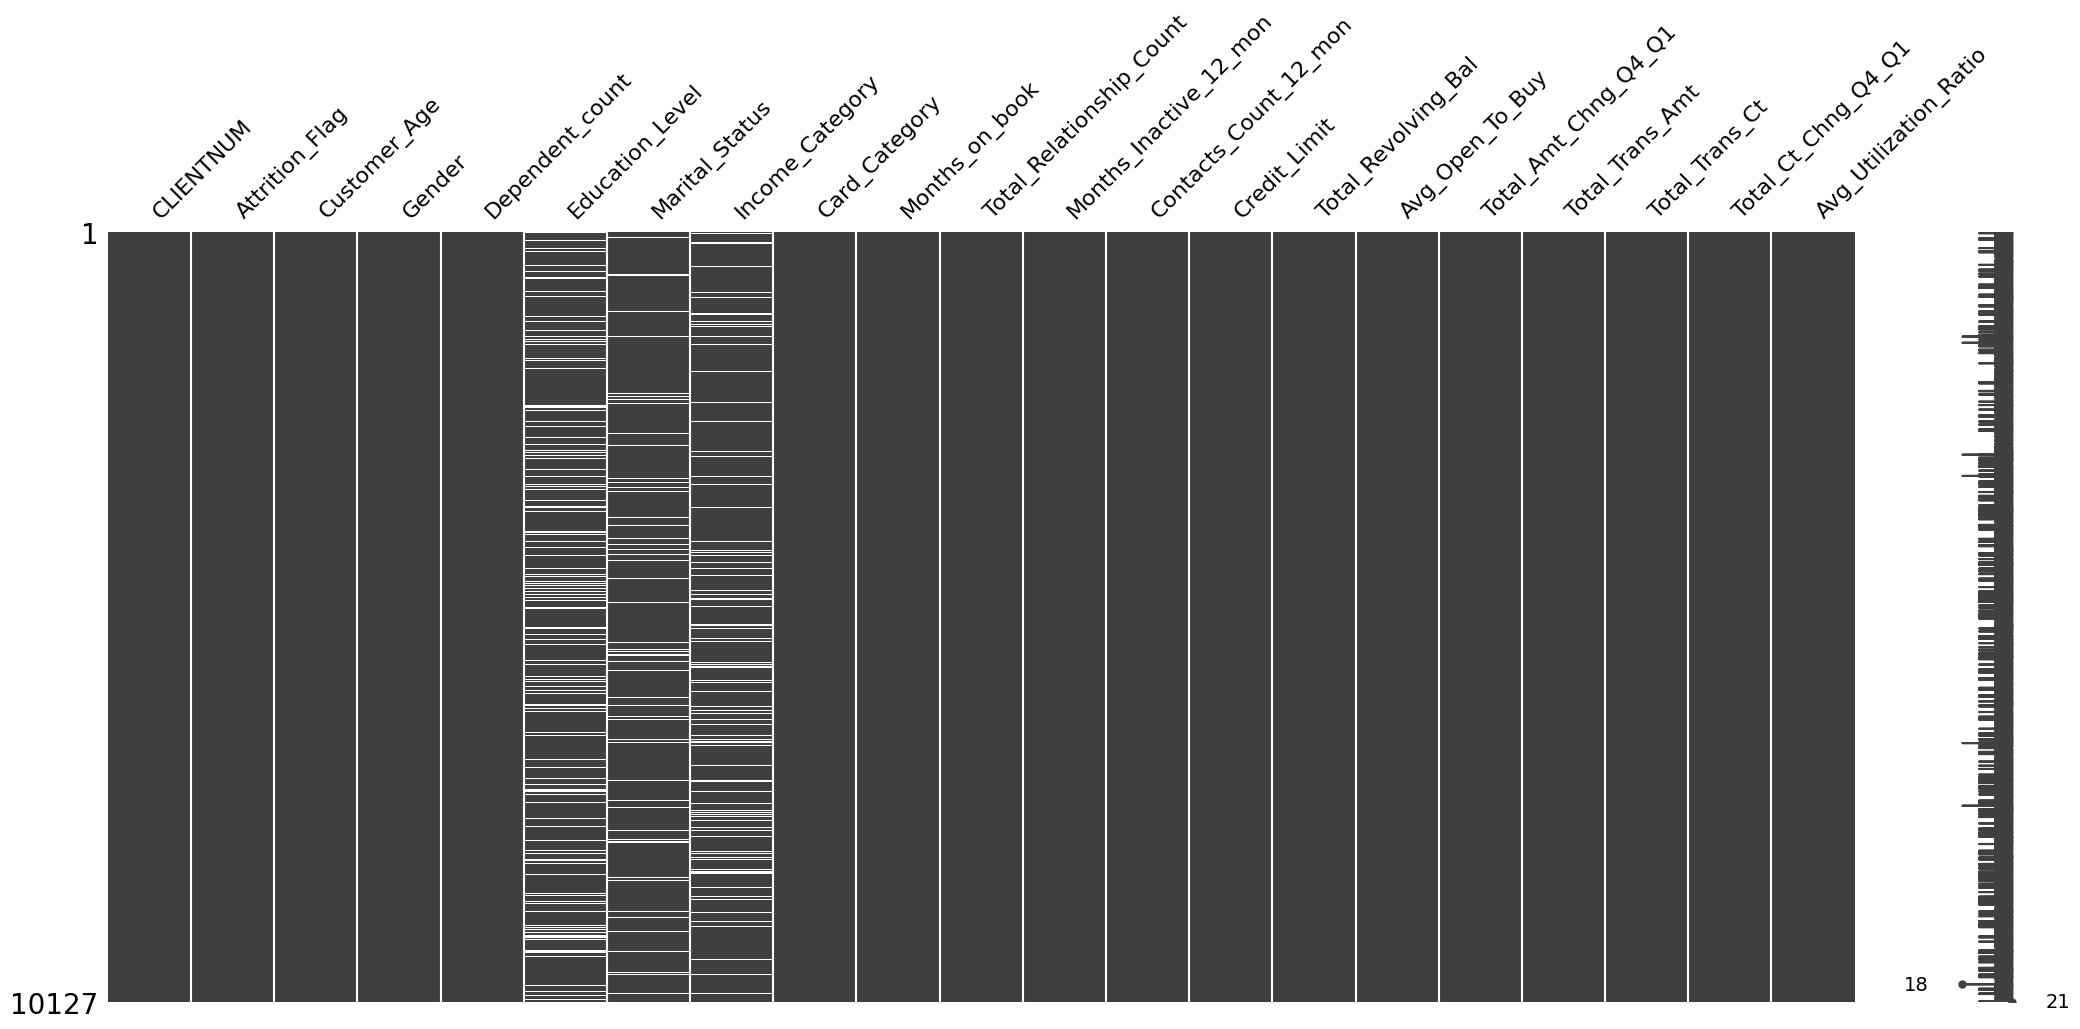

In [6]:
msno.matrix(data)

As one can see the missing values are only in some columns.
To better mimic a real world scenario, in the next block I will use a function to randomly select some data point and make them missing values. I will skip those column where there are already some.

The amount of missing values is a percentage of the size of the dataset. Notice also that I will not alter the original dataset but rather introduce the missing values in a copy of the original one.

Finally, since in real world scenario missing data do not change, I will introduce an arbitrary seed to ensure reproducibility, so every time the function is run the same data points are selected.

<AxesSubplot: >

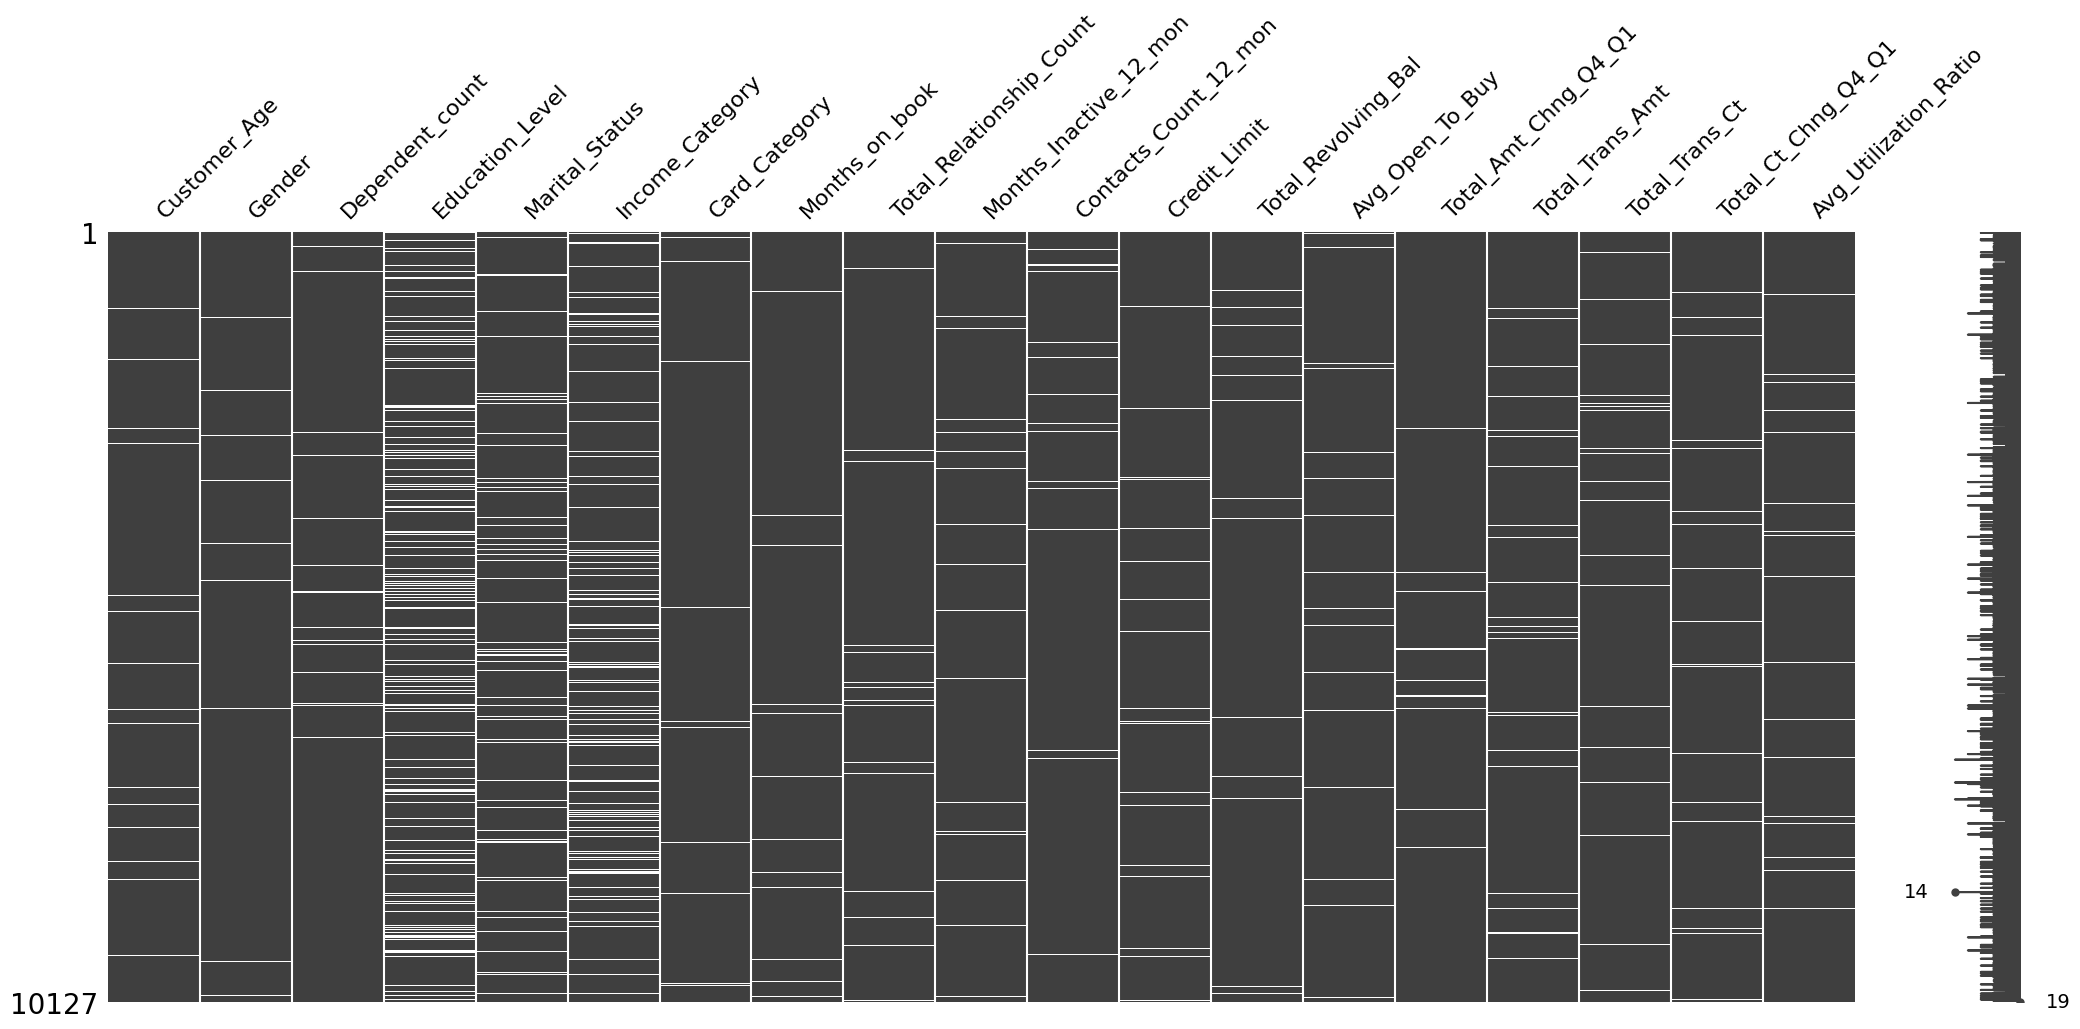

In [7]:
data_copy = data.copy()

# X is going to be the dataset without the client number as it shouldn't be correlated with churn
# y is going to be the attrition flag, the target

X = data_copy.iloc[:,2:]
y = data_copy.iloc[:,1]

random.seed(42)  # Ensures reproducibility
np.random.seed(42)  # Sets numpy's seed

def add_nan(dataset, missing_percent):

    total_values = dataset.size
    missing_values = int((missing_percent / 100) * total_values)

    for i in range(missing_values):
        
        rand_row = random.randint(0, dataset.shape[0] - 1) #randomly select a row
        rand_col = random.randint(0, dataset.shape[1] - 1) #randomly select a column
        
        if rand_col not in [3, 4, 5]:   #only select columns where there are no missing values
            dataset.iloc[rand_row, rand_col] = np.nan
        
    return dataset

add_nan(X,2)
msno.matrix(X)

Amount of missing values in each column 

In [8]:
X.isnull().sum()

Customer_Age                 180
Gender                       199
Dependent_count              199
Education_Level             1519
Marital_Status               749
Income_Category             1112
Card_Category                191
Months_on_book               189
Total_Relationship_Count     171
Months_Inactive_12_mon       215
Contacts_Count_12_mon        212
Credit_Limit                 199
Total_Revolving_Bal          201
Avg_Open_To_Buy              197
Total_Amt_Chng_Q4_Q1         195
Total_Trans_Amt              215
Total_Trans_Ct               188
Total_Ct_Chng_Q4_Q1          238
Avg_Utilization_Ratio        204
dtype: int64

In [9]:
X.isnull().sum()/X.shape[0]

Customer_Age                0.017774
Gender                      0.019650
Dependent_count             0.019650
Education_Level             0.149995
Marital_Status              0.073961
Income_Category             0.109805
Card_Category               0.018860
Months_on_book              0.018663
Total_Relationship_Count    0.016886
Months_Inactive_12_mon      0.021230
Contacts_Count_12_mon       0.020934
Credit_Limit                0.019650
Total_Revolving_Bal         0.019848
Avg_Open_To_Buy             0.019453
Total_Amt_Chng_Q4_Q1        0.019255
Total_Trans_Amt             0.021230
Total_Trans_Ct              0.018564
Total_Ct_Chng_Q4_Q1         0.023502
Avg_Utilization_Ratio       0.020144
dtype: float64

The target column needs to be mapped to numerical values, 0 for Existing Customer and 1 for Attrited one. 

In [10]:
y = y.map({'Existing Customer': 0 , 'Attrited Customer': 1})
y

0        0
1        0
2        0
3        0
4        0
        ..
10122    0
10123    1
10124    1
10125    1
10126    1
Name: Attrition_Flag, Length: 10127, dtype: int64

## Exploratory Data Analysis 

To better understand how the data are distributed and what has to be done on the data

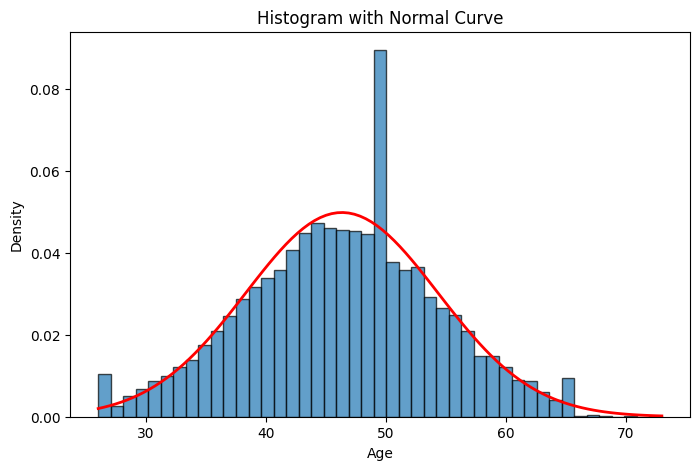

In [11]:
age_data = X['Customer_Age']
# Compute mean and standard deviation
mu, sigma = age_data.mean(), age_data.std()

# Generate normal distribution curve
x = np.linspace(min(age_data), max(age_data), 100)  #generates evenly spaced numbers in the range of customer age
pdf = stats.norm.pdf(x, mu, sigma)                    #density function

plt.figure(figsize=(8, 5))
plt.hist(age_data, bins=45, edgecolor='black', alpha=0.7, density=True)
plt.plot(x, pdf, 'r', linewidth=2)  # Overlay normal curve

plt.xlabel("Age")
plt.ylabel("Density")
plt.title("Histogram with Normal Curve")

plt.show()


The data about the age are fairly normally distributed. In the next step I might consider standardizing to obtain better result with distance based models 

In [12]:
labels = ['Male', 'Female']
sizes = X['Gender'].value_counts().values

px.pie(sizes, names=labels, title= "M-F distribution", hole=0.3)

Notice that the values that we see in the donout chart above are all bit approximated, they are not exactly the same but the difference in percetage points is very small.

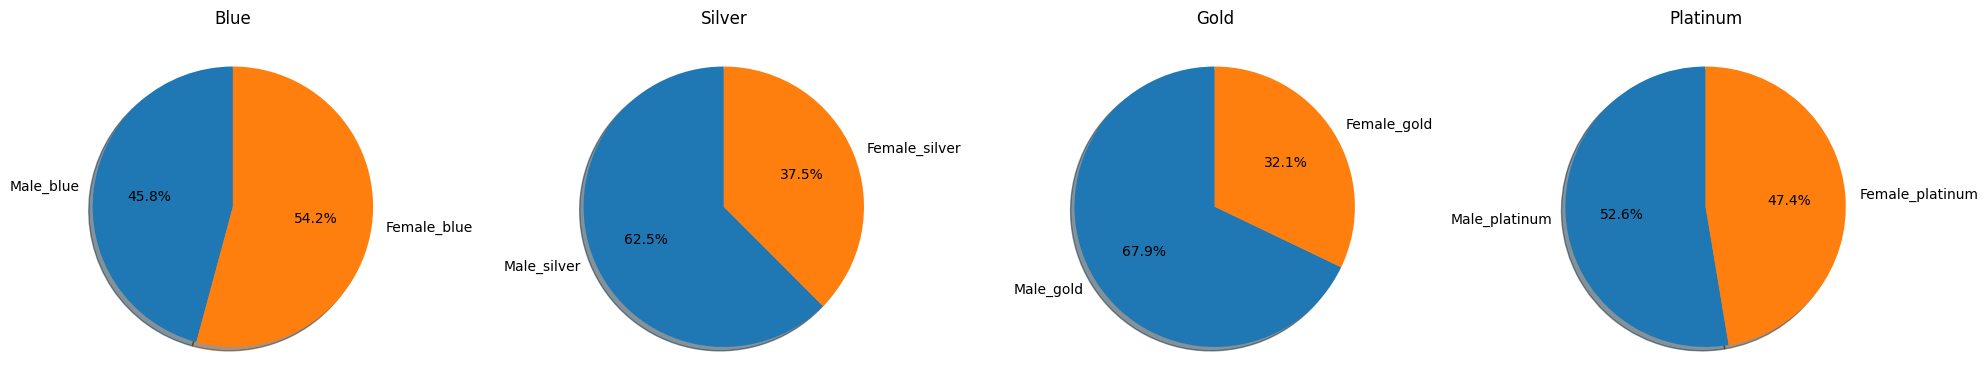

In [13]:
#pie charts for each card category for male and female customers
#fig is the whole figure with 4 subplots
#ax is each individual subplot

fig, ax = plt.subplots(1,4, figsize=(20,5))

#blue card
# We select those who are male/female and hold a blue card. We are given a dataframe which rows (.shape[0]) 
#corresponds to the nuumber of people of our interest 

X_male_blue = X[(X['Gender']== 'M') & (X['Card_Category'] == 'Blue')].shape[0]  #here we use Boolean indexing
X_female_blue = X[(X['Gender']== 'F') & (X['Card_Category'] == 'Blue')].shape[0]

ax[0].pie([X_male_blue, X_female_blue], labels=['Male_blue', 'Female_blue'], autopct='%1.1f%%', shadow=True, startangle=90)
ax[0].set_title("Blue")

#silver card
X_male_silver = X[(X['Gender']== 'M') & (X['Card_Category'] == 'Silver')].shape[0]
X_female_silver = X[(X['Gender']== 'F') & (X['Card_Category'] == 'Silver')].shape[0]

ax[1].pie([X_male_silver, X_female_silver], labels=['Male_silver', 'Female_silver'], autopct='%1.1f%%', shadow=True, startangle=90)
ax[1].set_title("Silver")

#gold card
X_male_gold = X[(X['Gender']== 'M') & (X['Card_Category'] == 'Gold')].shape[0]
X_female_gold = X[(X['Gender']== 'F') & (X['Card_Category'] == 'Gold')].shape[0]

ax[2].pie([X_male_gold, X_female_gold], labels=['Male_gold', 'Female_gold'], autopct='%1.1f%%', shadow=True, startangle=90)
ax[2].set_title("Gold")

#platinum card
X_male_platinum = X[(X['Gender']== 'M') & (X['Card_Category'] == 'Platinum')].shape[0]
X_female_platinum = X[(X['Gender']== 'F') & (X['Card_Category'] == 'Platinum')].shape[0]

ax[3].pie([X_male_platinum, X_female_platinum], labels=['Male_platinum', 'Female_platinum'], autopct='%1.1f%%', shadow=True, startangle=90)
ax[3].set_title("Platinum")

plt.tight_layout()
plt.show()

The percentage points of the category Blue and Platinum are almost the same. They differ more in the Silver and Gold cards, where males are more than females.

At this point one could ask  if there is a gender that churns more than the other.

In [14]:
#before we separated the matrix X from the target column y to create the missing values in X. 
#I concatenate X and y to use it in the groupby operation
xy = pd.concat([X, y], axis=1)

# Attempt the groupby operation and calculate the mean.
gender_attrition_mean = xy.groupby('Gender')['Attrition_Flag'].mean()

gender_attrition_mean


Gender
F    0.172696
M    0.146279
Name: Attrition_Flag, dtype: float64

As we can see the difference in churning is very subtle.
Let's continue EDA

Text(0.5, 1.0, 'Proportion of Income Category')

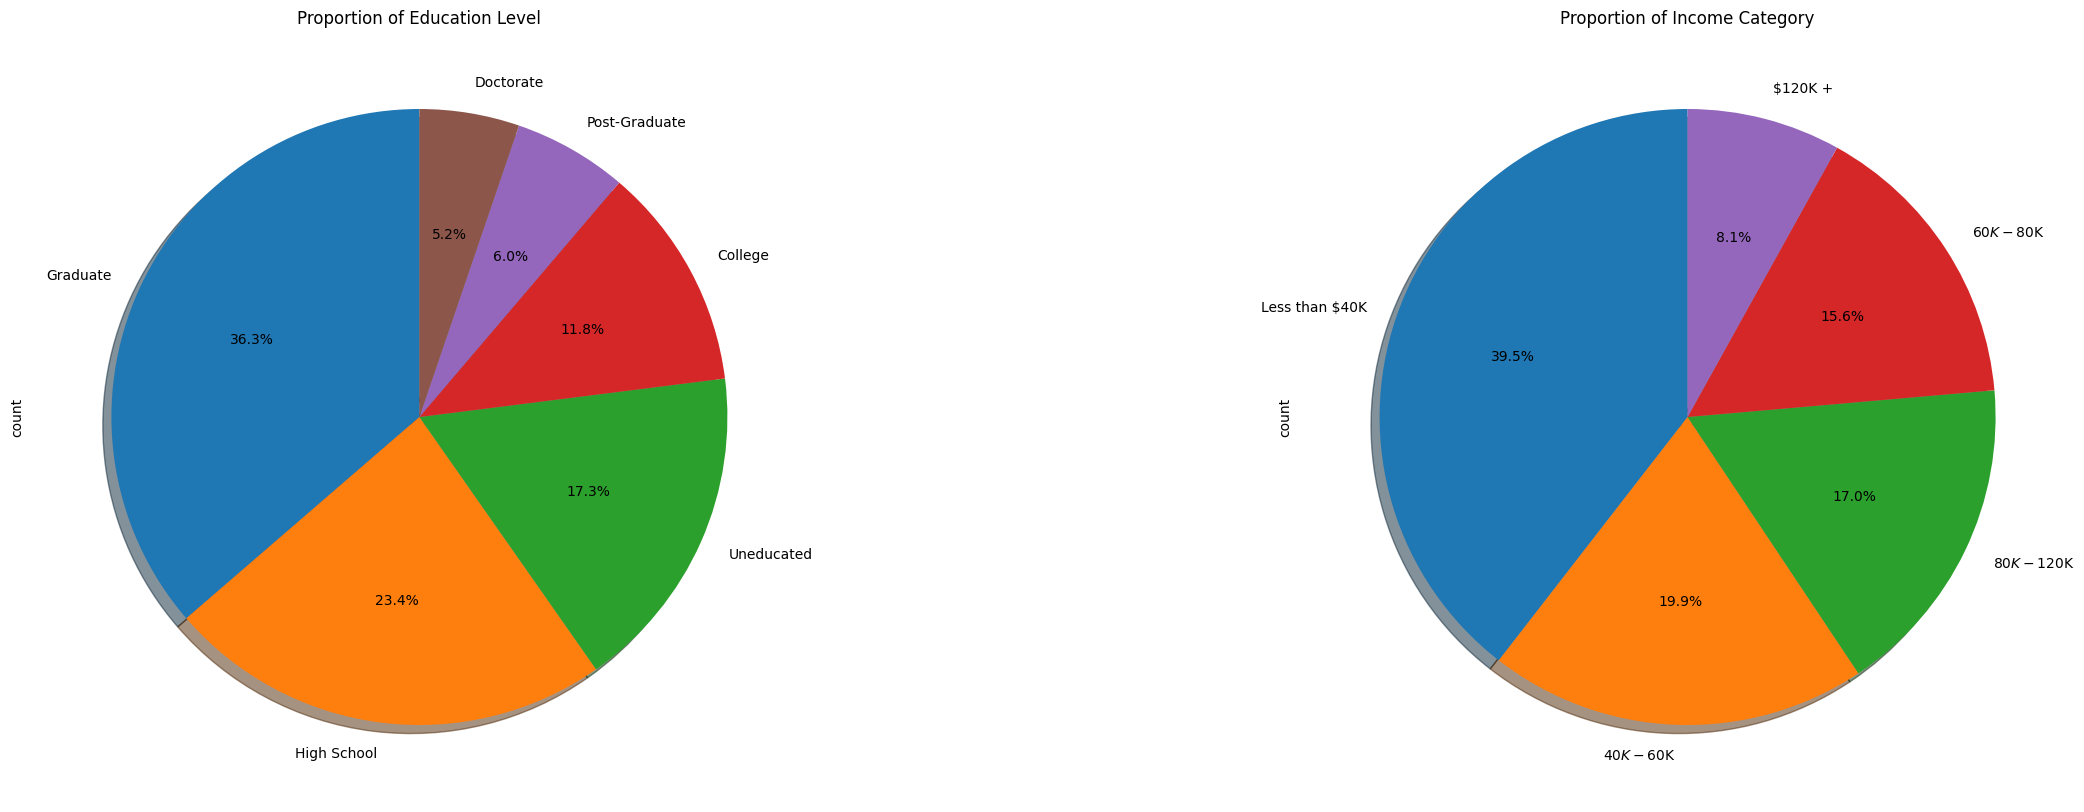

In [15]:
fig, ax = plt.subplots(1,2, figsize=(30,10))


X['Education_Level'].value_counts().plot.pie(autopct='%1.1f%%', shadow=True, startangle=90, ax=ax[0])
ax[0].set_title("Proportion of Education Level")
X['Income_Category'].value_counts().plot.pie(autopct='%1.1f%%', shadow=True, startangle=90, ax=ax[1])
ax[1].set_title("Proportion of Income Category")



In [16]:
px.pie(X, names="Card_Category",title='Propotion Of Card Categories',hole=0.3)

As we can see 90% of the customer hold a Blue type card, this makes the information "Card Category" less relevant as of course the majority of the churners are going to have a Blue card. Thus the column does not seem very predictive, I will later drop it.

In [17]:
px.histogram(X, x="Months_on_book", hover_data=X.columns)

In this case the distribution is very flat, I expect the kurtosis, the measure of the "taildness" to be very low, as the data points are very spread around the mean.

In [18]:
kurtosis_value = X["Months_on_book"].kurt()
print(f"Kurtosis of Months_on_book: {kurtosis_value:.3f}")

print(X["Months_on_book"].corr(y))

Kurtosis of Months_on_book: 0.399
0.01445650123056196


As expected the kurtosis is very low and the correlation with the target is also low, meaning that this feature, as it is, might not be relevatn to our churn predictor. 

I will try to apply a log transformation to see if it becomes more relevant to my model.

One might ask why there is a really high value at 36, this might derive from a policy that the bank applies around that period or some mistake in taking the data. This we cannot know.

In [19]:

log_month = FunctionTransformer(np.log1p, validate=True).fit_transform(data['Months_on_book'].values.reshape(-1, 1))
#show an histogram of the transformed data
px.histogram(log_month, x=0, nbins=50, title="Log transformation of Months_on_book")


In this case the log transformation didn't imporve the shape the distribution, for the time being I consider dropping it as it would bias the model 

In [20]:
px.histogram(X, x="Total_Relationship_Count", title="Tot. # products held")

The distribution is almsot uniform, I might consider dropping this feature as it might not be relevant for a churn model.

In [21]:
px.histogram(X, x="Credit_Limit", title="Credit Limit")

We can clearly see a right skew. This is coming from the majority of card being of the same type. We might consider log transformation to get a more normal distributed data, but in this case "Crediti limit" does not seem predictive for a Churn model. (The cards are almost all of the same type so they have similar limits)

In [22]:
px.histogram(X, x= "Total_Trans_Amt", title="Total_Trans_Amt")

Here we can see a multimodal distribution, meaning that we have some underlying groups in our data. It is interesting to segment the customers into different groups. After the imputation I will use KbinsDiscretizer. 
In the next block we can visualize the rest of our data.

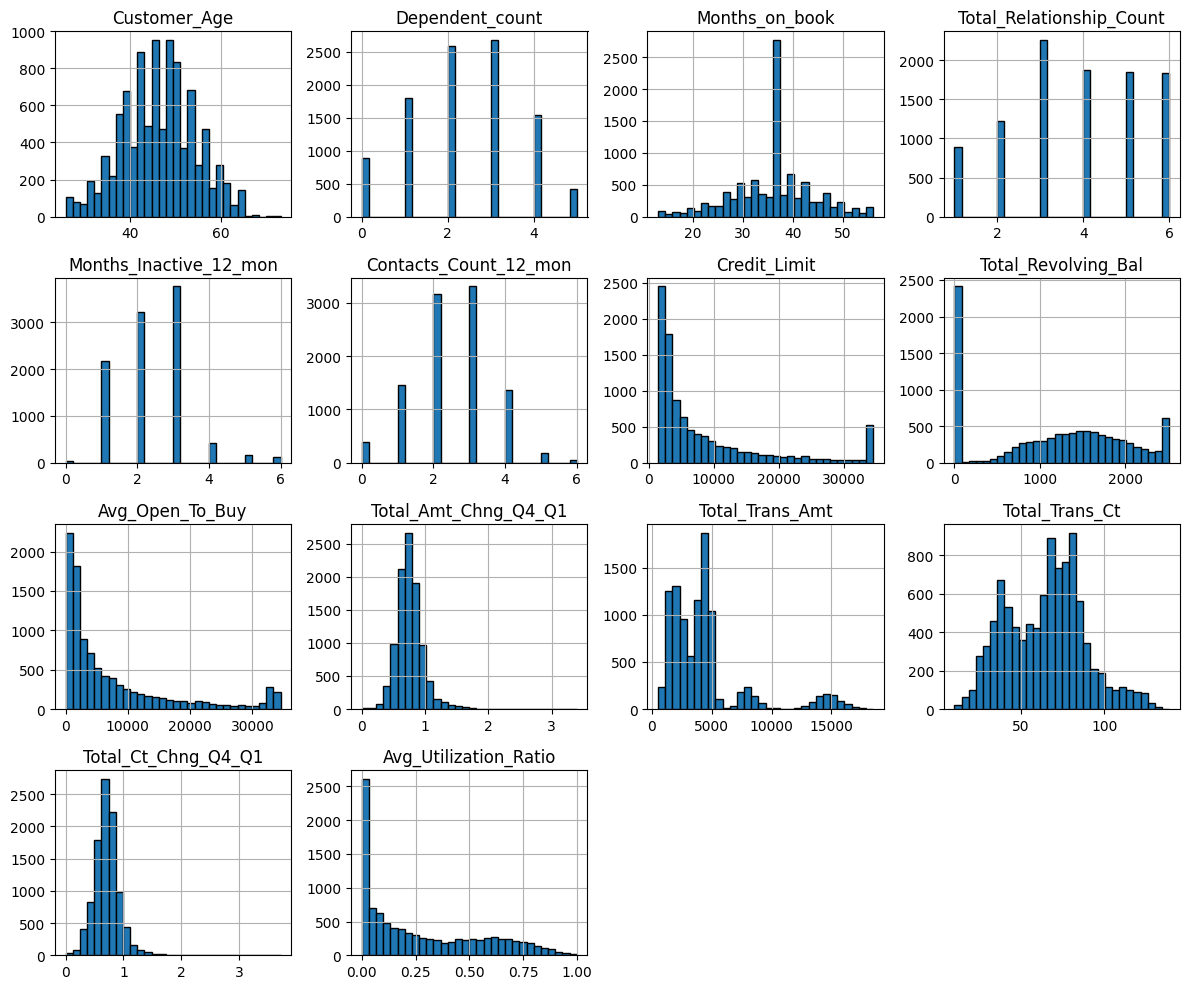

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

X.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.tight_layout()
plt.show()


Once again, as seen above, the features 'Months_on_book', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Avg_Utilization_Ratio', and 'Credit_Limit' are highly skewed. In this case, log transformation is not particularly effective (as seen above), so I drop them.

In the final part of the project, I will propose at least one alternative method to utilize these features without directly removing them.


In [24]:
X.drop(['Months_on_book','Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Avg_Utilization_Ratio', 'Credit_Limit', 'Card_Category', 'Total_Relationship_Count'], axis=1, inplace=True)


## Definition of the Data Transformation Pipeline 

According to what I understood through EDA I will use the following pipelines. Notice that the columns with the green background are numerical and the pink one are categorical.

![](pipeline1.png)
![](pipeline2.png)
![](pipeline3.png)
![](pipeline4.png)
![](pipe_marital_gender.png)


In [25]:
X.columns

Index(['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level',
       'Marital_Status', 'Income_Category', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1'],
      dtype='object')

In [26]:
#Define a Function Trasfomer to use in the second pipeline to round the values yield by the knn imputer,
#done to have only discrete ordinal values
round_transformer = FunctionTransformer(lambda X: np.round(X).astype(int),feature_names_out="one-to-one")


Pipe1 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

custom_orders = [
    ['Uneducated', 'High School', 'College', 'Graduate', 'Post-Graduate', 'Doctorate'],
    ['Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +']
    
]

Pipe2 = Pipeline([
    ('ord_encoder', OrdinalEncoder(
        categories=custom_orders, 
        handle_unknown='use_encoded_value',  # Allow unseen categories
        unknown_value=np.nan  
    )),
    ('knn_imputer', KNNImputer(n_neighbors=5)),  # KNNImputer will replace nan values
    ('round_values', round_transformer)  # Ensure rounded integer values
])

Pipe3 = Pipeline([
    ('knn_imputer', KNNImputer(n_neighbors=5)),
    ('binner', KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans'))
])

Pipe4 = Pipeline([
    ('knn_imputer', KNNImputer(n_neighbors=5)),
    ('std_scaler', StandardScaler())
]) 



pipe_marital_gender = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('hot', OneHotEncoder(categories='auto',drop='first'))
    
])




final_transformation = ColumnTransformer(transformers=[
    ('pipe1', Pipe1,['Customer_Age', 'Months_Inactive_12_mon','Total_Amt_Chng_Q4_Q1','Total_Trans_Ct','Total_Ct_Chng_Q4_Q1' ] ),
    ('pipe2', Pipe2,['Education_Level','Income_Category']),
    ('pipe3', Pipe3,['Total_Trans_Amt']),
    ('pipe4', Pipe4,[ 'Contacts_Count_12_mon']),
    ('marital_gender', pipe_marital_gender,['Marital_Status', 'Gender' ]),
],
remainder='drop', #makes the column trasnformer to drop all those features that are not listed above 
                    #there shouldn't be as I already manually droped them, it's just for sanity.
verbose_feature_names_out=False, #original columns names are kept
sparse_threshold=0 #the output is hence going to be a dense matrix 
)


## Training and test split 

I divide the dataset into train and test, keeping for test 20% of the data.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=30, shuffle=True)

## Correlation visualization

To check everything worked well I will apply the pipeline to a copy of the dataset and use it to check correlation between features

In [28]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
y_train_copy = y_train.copy()
y_test_copy = y_test.copy()


X_train_transformed = final_transformation.fit_transform(X_train_copy)
X_test_transformed = final_transformation.transform(X_test_copy)


X_train_transformed = pd.DataFrame(X_train_transformed, columns=final_transformation.get_feature_names_out())
X_test_transformed = pd.DataFrame(X_test_transformed, columns=final_transformation.get_feature_names_out())


In [29]:
X_train_transformed.head()

,Customer_Age,Months_Inactive_12_mon,Total_Amt_Chng_Q4_Q1,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Education_Level,Income_Category,Total_Trans_Amt,Contacts_Count_12_mon,Marital_Status_Married,Marital_Status_Single,Gender_M
0,-0.789820,-0.337274,0.986341,-1.500343,2.533180,3.0,0.0,0.0,0.494763,0.0,1.0,0.0
1,0.590726,0.663920,-0.673541,-2.016538,0.377178,3.0,4.0,0.0,0.494763,1.0,0.0,1.0
2,2.096777,-1.338469,-0.687335,0.478404,0.419619,1.0,0.0,0.0,-1.336461,0.0,1.0,0.0
3,2.598793,0.663920,0.098925,-1.156213,-0.047232,0.0,1.0,0.0,-0.420849,1.0,0.0,1.0
4,0.214214,0.663920,-1.427615,-1.199229,-1.447784,1.0,0.0,0.0,0.494763,1.0,0.0,0.0


Now that I am all set I can try to look for some correlation and see if there is something interesting for us or for the bank.

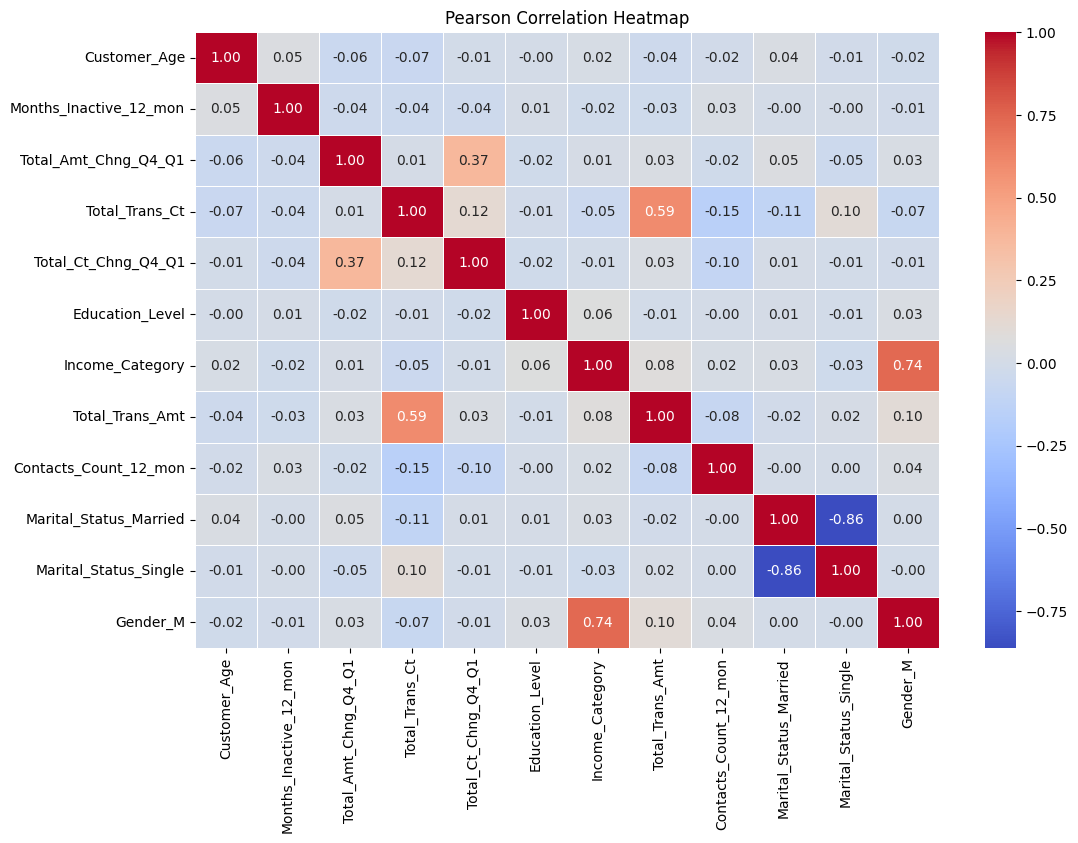

In [30]:
# Compute Pearson Correlation Matrix
corr_matrix = X_train_transformed.corr(method="pearson")

# Plot Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Pearson Correlation Heatmap")
plt.show()

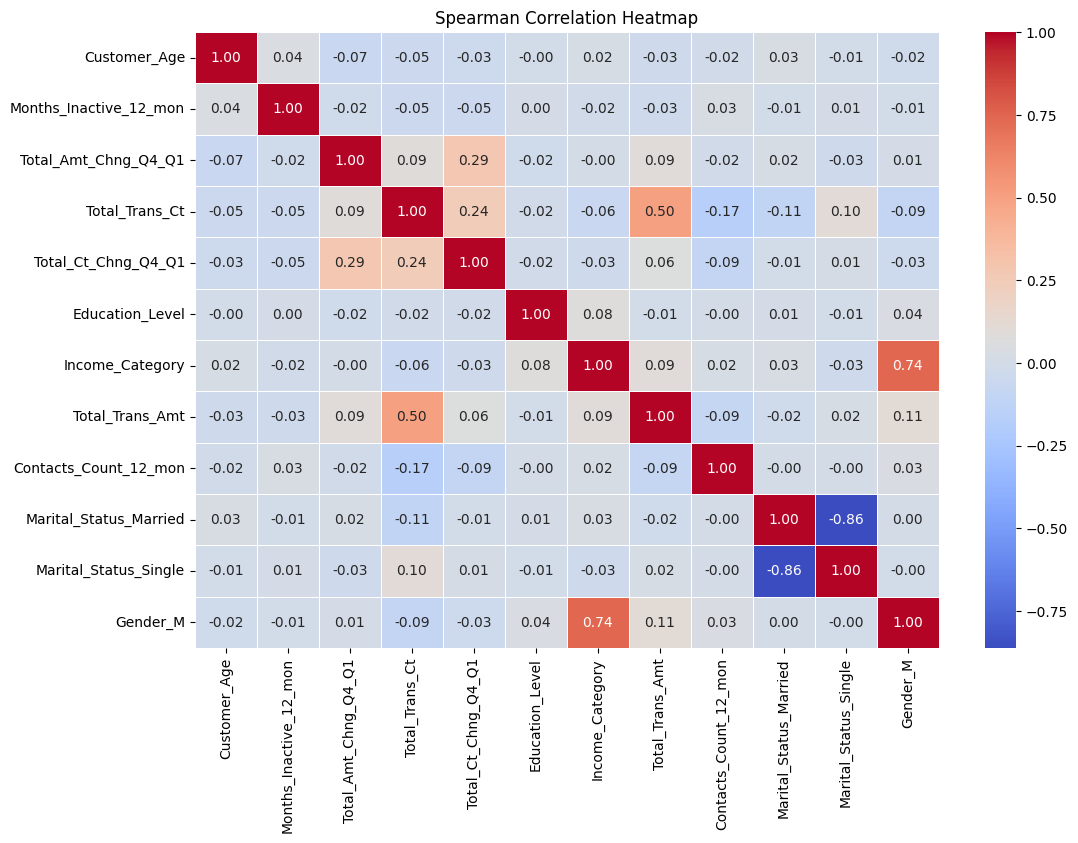

In [31]:
# Compute Spearman Correlation Matrix
spearman_corr = X_train_transformed.corr(method="spearman")

# Plot Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(spearman_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Spearman Correlation Heatmap")
plt.show()

Even though the Pearson correlation matrix measures linear relationships between the data and the Spearman the monotonicity relationships we get pretty much the same values, that is beacuse the data are standardized and there are few extreme oulier. 

From the matrix we see that the features that are mostly correlated are:
  1. Total_Trans_Amt and Total_Trans_Ct : customers who transact more tend to spend more,
  2. Months_Inactive_12_mon has very low correlations with all features. This suggests inactivity doesn’t strongly  relate to transactions or spending habits.
  3. Income_category and Gender_M are highly correlated, this might suggest a gender bias in income or it might simply derive from the fact that I applied One hot encoding on the gender feature and Gender_F has been dropped in the final transformation. 



### Check for balance 

In [32]:
y_train.value_counts()

Attrition_Flag
0    6799
1    1302
Name: count, dtype: int64

From this we can see that the classes are very unbalanced, that is why I will need to use some oversampler strategy like SMOTE. I also take into consideration the possibility of using an undersampling strategy, like TomekLinks.

In this case I will also pay attention to the quality of the data that such oversamplying strategy will provide as there is the possibility that noise is created instead of relevant data points.

## Model Selection  

Here I define a model pipeline to better tune after with nested cross validation.

In [33]:
model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('over_sampler', SMOTE(sampling_strategy='minority')),
    ('under_sampler', TomekLinks()), 
    ('dim_reduction', PCA(n_components=8)),
    ('classifier', SVC())
])

Let's run a fit method to check everything is working fine

In [34]:
model_pipeline.fit(X_train,y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('pipe1',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['Customer_Age',
                                                   'Months_Inactive_12_mon',
                                                   'Total_Amt_Chng_Q4_Q1',
                                                   'Total_Trans_Ct',
                                                   'Total_Ct_Chng_Q4_Q1']),
                                                 ('pipe2',
                                                  Pipeline(steps=[('ord_encoder',
                                                                   OrdinalEncoder(categories...
                                                  ['Contacts_Count_12_mon']),
                                                 ('marital_gender',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('hot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Marital_Status',
                                                   'Gender'])],
                                   verbose_feature_names_out=False)),
                ('over_sampler', SMOTE(sampling_strategy='minority')),
                ('under_sampler', TomekLinks()),
                ('dim_reduction', PCA(n_components=8)), ('classifier', SVC())])

In the following block I will define some lists of dictionaries where I specify the different combinations of estimators and their hyperparameters. Which combinations are going to be used for the model selection.

In [35]:
over_sampler_configs = [

    {'over_sampler': [None]},

    {
        'over_sampler': [SMOTE()],
        'over_sampler__sampling_strategy': ['minority', 0.4, 0.5, 0.8, 0.9 ], 
        'over_sampler__k_neighbors': [1, 2, 3, 5, 7]
    },
    
]

under_sampler_configs = [

    {'under_sampler': [None]},

    {
        'under_sampler': [TomekLinks(sampling_strategy='majority')],
    },

    {
        'under_sampler': [RandomUnderSampler()],
        'under_sampler__sampling_strategy': ['majority' ],
    },

]

dim_reduction_configs = [
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [ 5, 7, 9,10, 0.9]  
    },
    {
        'dim_reduction': [LDA()],  
    },

    {
        'dim_reduction': [SFS(estimator=Perceptron(), cv = None, scoring = 'f1')],
        'dim_reduction__estimator': [Perceptron(), LogisticRegression()],
        'dim_reduction__k_features' : [7,8, 9, 10],
        'dim_reduction__forward' : [True, False], #either add or remove features
    }

]

classifier_configs = [

    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3,5,7,9]
    },
    
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [50, 80, 100, 150], 
        'classifier__max_depth': [5,7],  # Added depth restriction to prevent overfitting 
        'classifier__min_samples_split': [5],  # Prevent excessive branching
        'classifier__min_samples_leaf': [5],  # Ensure each leaf has enough samples
        'classifier__max_features': ['sqrt'],  
        'classifier__class_weight': ['balanced']
    },

    {
        'classifier': [SVC()],
        'classifier__C': loguniform(0.001, 100),  # Regularization parameter
        'classifier__kernel': ['rbf'],  
        'classifier__gamma': ['scale'],  
       'classifier__class_weight': ['balanced']
    },
    {
        'classifier': [LogisticRegression(solver='saga')],
        'classifier__C' : loguniform(0.001,100),
        'classifier__penalty': ['l1','l2'],
        'classifier__class_weight' : [None, 'balanced']

    },
    
    
]


In [36]:
# Define a list of all possible configurations
all_configs = []
for configuration in itertools.product(over_sampler_configs,under_sampler_configs,dim_reduction_configs,classifier_configs):
    # Merging of three dictionary into one
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    all_configs.append(dict(all_parameters)) # by dict(all_parameters) we create a dict from a list of pairs 

In [37]:
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 72'

Define a RandomizedSearchCV object which takes the list of all configurations, use a 2-fold cross validation using F1 as scoring metric. This represents the "inner loop" in the nested cross validation procedure. As said earlier it is used for finding the best hyperparameter configurations.

In [38]:
rs = RandomizedSearchCV(model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs) * 2,
    n_jobs=-1,
    cv = 2,
    scoring='f1',
    verbose=3,
    error_score='raise'
)

Now, to implement the "outer loop" of the nested cross validation I use cross_validate to return the best model for each fold of the inner loop. This is done to prevant us from using multiple times the same test set, which would increase the probability of overfitting.

In [39]:
# Define Stratified K-Fold Cross-Validation
stratified_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

scores = cross_validate(rs, X_train, y_train, scoring='f1', cv = stratified_cv, return_estimator=True, verbose=3, error_score='raise') 

Fitting 2 folds for each of 144 candidates, totalling 288 fits
[CV 1/2] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__max_depth=7, classifier__max_features=sqrt, classifier__min_samples_leaf=5, classifier__min_samples_split=5, classifier__n_estimators=150, dim_reduction=PCA(), dim_reduction__n_components=0.9, over_sampler=SMOTE(), over_sampler__k_neighbors=1, over_sampler__sampling_strategy=0.4, under_sampler=TomekLinks(sampling_strategy='majority');, score=0.537 total time=   1.2s
[CV 2/2] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__max_depth=7, classifier__max_features=sqrt, classifier__min_samples_leaf=5, classifier__min_samples_split=5, classifier__n_estimators=150, dim_reduction=PCA(), dim_reduction__n_components=0.9, over_sampler=SMOTE(), over_sampler__k_neighbors=1, over_sampler__sampling_strategy=0.4, under_sampler=TomekLinks(sampling_strategy='majority');, score=0.559 total time=   1.0s
[CV 1

Let's now access the best estimator

In [40]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['over_sampler'])
    print(estimator.best_estimator_.get_params()['under_sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

SMOTE(k_neighbors=1, sampling_strategy=0.8)
RandomUnderSampler(sampling_strategy='majority')
SequentialFeatureSelector(cv=None, estimator=Perceptron(), forward=False,
                          k_features=(10, 10), scoring='f1')
RandomForestClassifier(class_weight='balanced', max_depth=7, min_samples_leaf=5,
                       min_samples_split=5, n_estimators=80) {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 80, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.6386363636363637
----------
SMOTE(k_neighbors=3, sampling_strategy=0.8)
TomekLinks(sampling_strategy='majority')
SequentialFeatureSelector(cv=None, estimator=LogisticRegression(),
                          forw

In [41]:
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.7162162162162162, F1 on test set:0.6922094508301405
F1 on training set:0.6942942942942943, F1 on test set:0.6716604244694132


## Refinement of the selected model 

In [42]:
best_model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('over_sampler', SMOTE(sampling_strategy=0.8)),
    ('under_sampler', TomekLinks(sampling_strategy='majority')),
    ('dim_reduction', SFS(cv=None, estimator=LogisticRegression(),
                          forward=False, k_features=(9, 9), scoring='f1')),
    ('classifier',RandomForestClassifier(class_weight='balanced', max_depth=7, min_samples_leaf=5,
                       min_samples_split=5, n_estimators=150))
])

In [43]:
best_model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('pipe1',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['Customer_Age',
                                                   'Months_Inactive_12_mon',
                                                   'Total_Amt_Chng_Q4_Q1',
                                                   'Total_Trans_Ct',
                                                   'Total_Ct_Chng_Q4_Q1']),
                                                 ('pipe2',
                                                  Pipeline(steps=[('ord_encoder',
                                                                   OrdinalEncoder(categories...
                ('over_sampler', SMOTE(sampling_strategy=0.8)),
                ('under_sampler', TomekLinks(sampling_strategy='majority')),
                ('dim_reduction',
                 SequentialFeatureSelector(cv=None,
                                           estimator=LogisticRegression(),
                                           forward=False, k_features=(9, 9),
                                           scoring='f1')),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=7,
                                        min_samples_leaf=5, min_samples_split=5,
                                        n_estimators=150))])

Let's now use this model pipeline to predict the test set

In [44]:
y_pred = best_model_pipeline.predict(X_test)
f1_score(y_test, y_pred)

0.6954314720812182

Let us visualize the confusion matrix

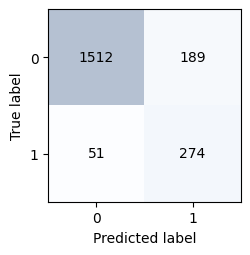

In [45]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred) #compute the confusion matrix 

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j],
                va='center', ha='center')

ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In this case the number of false positive is pretty high. 
To further assess the model we can measure also the accuracy, precision and recall. 

In [46]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.88
Precision: 0.59
Recall: 0.84


In this case we can see that the recall is good, almost 90%, meaning that the model captures 90% of the churners, rarely missing some of them. This come at the cost of precision which is not very high, when the model predicts that a customer is going to churn is correct 59% of the time. This is due to the high unbalace found in the dataset.

In the pipline it is applied the SMOTE oversampler which in this case, most probabilly, creates some noisy data.

I will check this intuition down here, but before that let's assess this model selected by the RandomizedSearch. 

Visualization of learning curve

In [47]:
train_sizes, train_scores, test_scores = learning_curve(best_model_pipeline,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes= [0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 2,
                                                       n_jobs = -1,
                                                       scoring = 'f1',
                                                       shuffle = False,
                                                       error_score='raise')

(0.3, 1.03)

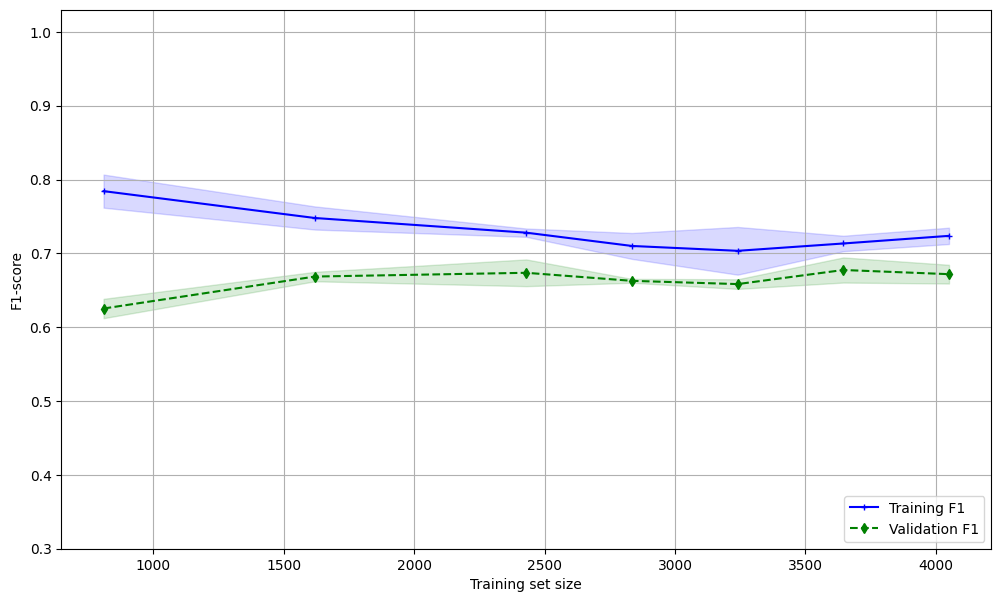

In [48]:
train_mean = np.mean(train_scores, axis=1) #F1-score mean across cross-validation folds for each training size.
train_std = np.std(train_scores, axis=1) #stadard deviation used to then show the variability of the f1 scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training F1')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')   # Creates a shaded confidence interval representing 
                                             # the ±1 standard deviation.

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation F1')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.3, 1.03])

Let's visualize the validation curve, in particular how the f1 score changes in relation to the depth of the trees in the forest.

In [49]:
range_depth = [3,4,5,6,7,8,10]
train_scores, test_scores = validation_curve(best_model_pipeline,
        X=X_train, 
        y=y_train, 
        param_range=
        range_depth, 
        param_name='classifier__max_depth',
        cv=2, 
        n_jobs=-1, 
        scoring='f1'
)

(1.0, 8.0)

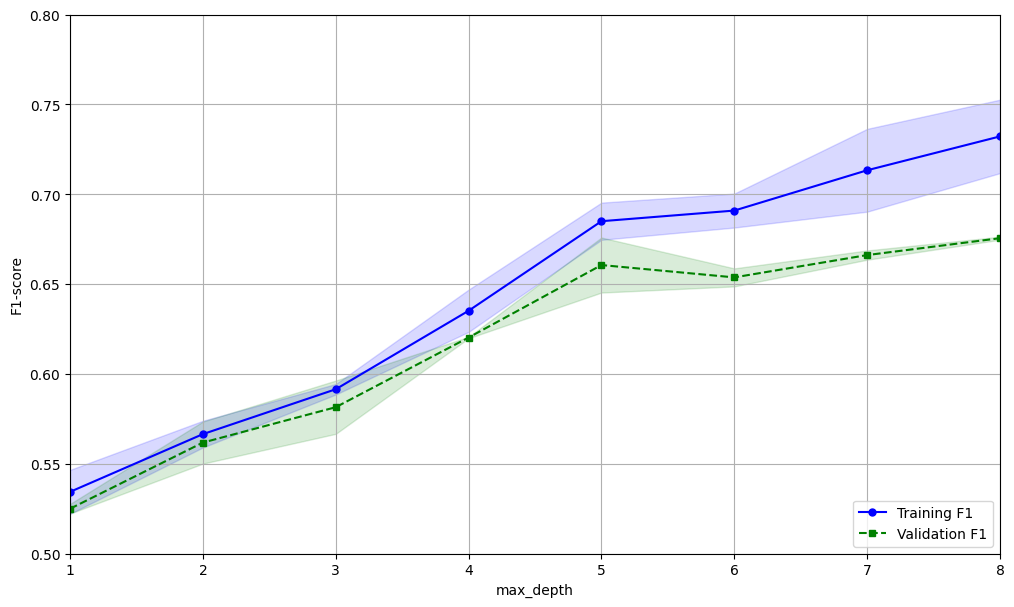

In [50]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_C, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training F1')

ax.fill_between(range_C,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_C, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation F1')

ax.fill_between(range_C,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('max_depth')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.5, 0.8])

ax.set_xlim([1,10])

This curve has a behaviour that I would expect as the deeper the tree the higher the possibility of overfitting, hence the distance between the lines towords the right.

The reason why the precision results are so low must be found in the data, let's see how they are distributed in a scatter plot in 3D, the first 3 Pricipal Components.

In [51]:
tomek = TomekLinks()
X_train_tomek, y_train_tomek = tomek.fit_resample(X_train_transformed, y_train)

# 2. Reduce dimensionality to 3 using PCA
pca = PCA(n_components=3)
X_train_pca_3d = pca.fit_transform(X_train_tomek)

evr = pca.explained_variance_ratio_
total_var = evr.sum() * 100
cumsum_evr = np.cumsum(evr)

print("Explained Variance Ratio:", evr) # fraction of the total dataset variance captured by each individual pc.
print("Total Variance Captured:", total_var) #how much the first  3 pc explain together
print("Cumulative Variance Captured:", cumsum_evr) #cumulative sum

Explained Variance Ratio: [0.18296006 0.16113165 0.13890493]
Total Variance Captured: 48.299664572561575
Cumulative Variance Captured: [0.18296006 0.34409171 0.48299665]


The first 3 Pricipal Components explain 48% of the variance in the data, which is not very high but is the best we can do as we are bound to visualization in 3D.

I will aslo apply TomekLinks() to remove some Tomek Links and hence try to make the two classes more separable.

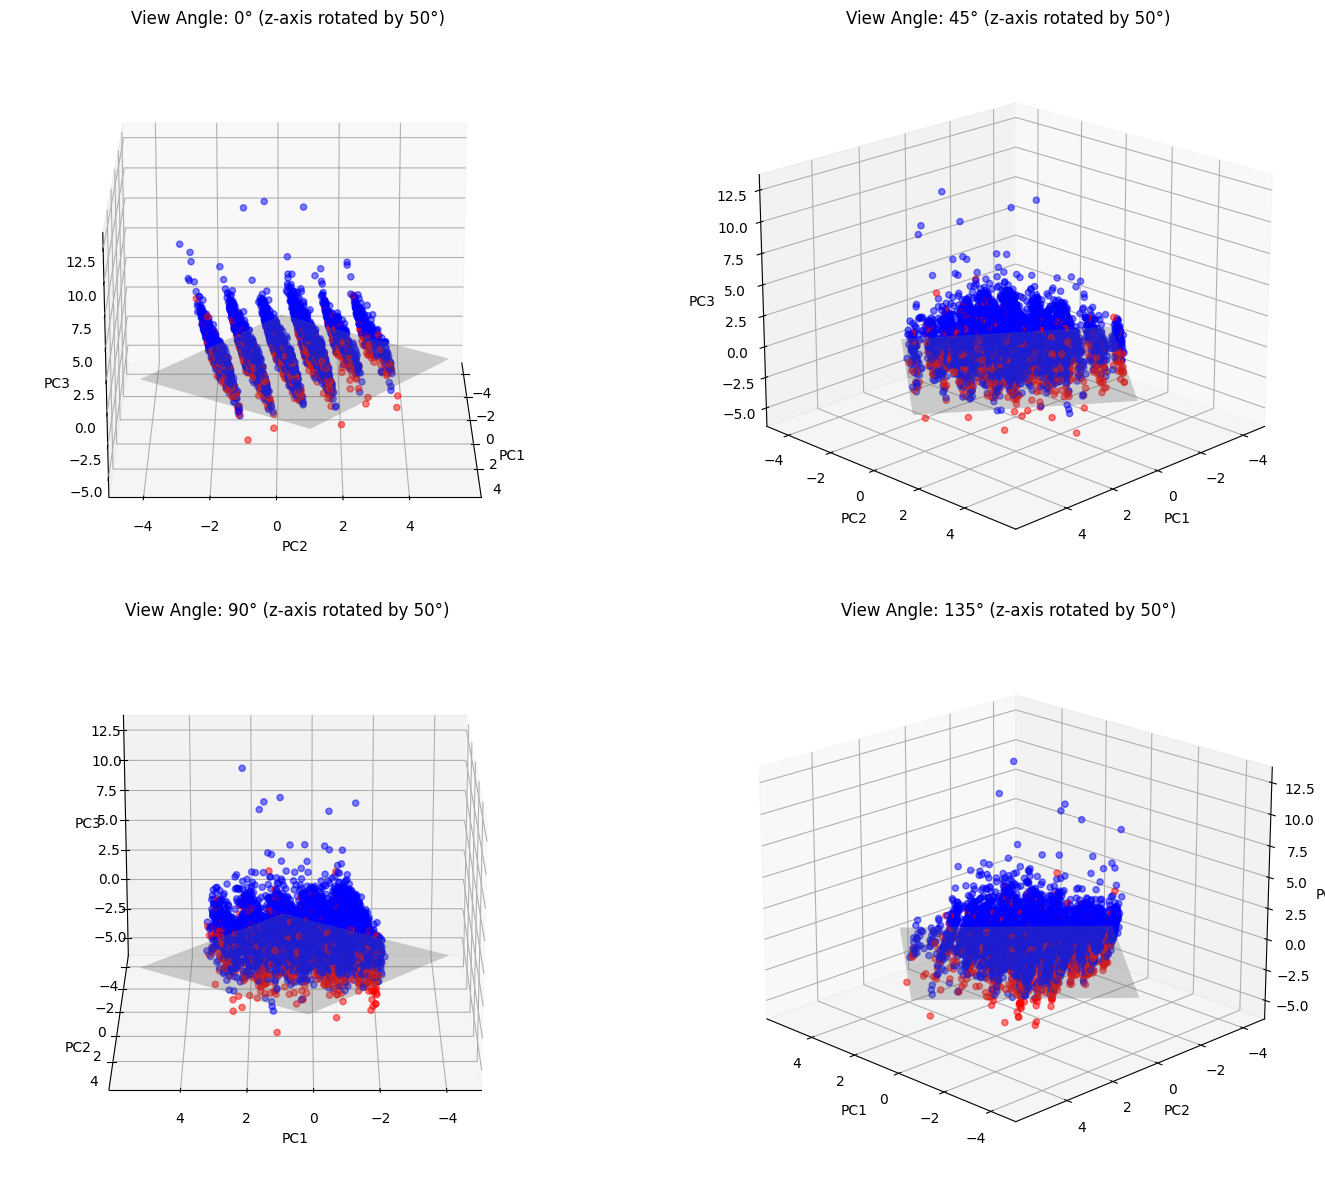

Training Precision (after TomekLinks & PCA): 0.625
Test Precision (after TomekLinks & PCA): 0.627


In [52]:
#Here I use the copy of the dataset I created at the beginning of the notebook 
#just not to mess with the one I just applied the the best model pipeline on.

# 1. Apply TomekLinks to the training data
tomek = TomekLinks()
X_train_tomek, y_train_tomek = tomek.fit_resample(X_train_transformed, y_train)

# 2. Reduce dimensionality to 3 using PCA
pca = PCA(n_components=3)
X_train_pca_3d = pca.fit_transform(X_train_tomek)

# 3. Train a Logistic Regression model on the 3D-transformed data
model = LogisticRegression()
model.fit(X_train_pca_3d, y_train_tomek)

# Extract the model's coefficients for the decision plane:
# The decision boundary is defined as: w1*x + w2*y + w3*z + b = 0
w1, w2, w3 = model.coef_[0]
b = model.intercept_[0]

# 4. Create a mesh grid over the range of PC1 and PC2 to plot the decision plane
x_vals = np.linspace(X_train_pca_3d[:, 0].min(), X_train_pca_3d[:, 0].max(), 30)
y_vals = np.linspace(X_train_pca_3d[:, 1].min(), X_train_pca_3d[:, 1].max(), 30)
xx, yy = np.meshgrid(x_vals, y_vals)
# Compute z from the plane equation: z = -(w1*x + w2*y + b) / w3
zz = -(w1 * xx + w2 * yy + b) / w3

# 5. Define functions to rotate points around the z-axis to improve the visualization
#        (since  we can't just move the graph around in 3D space)
def rotate_data_z(X, angle_degrees):
    """Rotate a set of 3D points X (shape: [n_samples, 3]) about the z-axis."""
    angle_rad = np.radians(angle_degrees)
    R = np.array([[np.cos(angle_rad), -np.sin(angle_rad), 0],
                  [np.sin(angle_rad),  np.cos(angle_rad), 0],
                  [0, 0, 1]])
    return X.dot(R.T)

def rotate_z_points(xx, yy, zz, angle_degrees):
    """Rotate mesh grid points (xx, yy, zz) about the z-axis."""
    angle_rad = np.radians(angle_degrees)
    R = np.array([[np.cos(angle_rad), -np.sin(angle_rad), 0],
                  [np.sin(angle_rad),  np.cos(angle_rad), 0],
                  [0, 0, 1]])
    # Flatten the grid points and combine into a single array of shape (N, 3)
    points = np.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T
    rotated_points = points.dot(R.T)
    # Reshape back to the original grid shape
    xx_rot = rotated_points[:, 0].reshape(xx.shape)
    yy_rot = rotated_points[:, 1].reshape(yy.shape)
    zz_rot = rotated_points[:, 2].reshape(zz.shape)
    return xx_rot, yy_rot, zz_rot

# 6. Define the additional z-axis rotation angle (in degrees)
z_rotation_angle = 50  # Adjust this value to change the angle of rotation 

# Rotate the PCA-transformed data and the decision plane mesh grid
X_train_pca_3d_rot = rotate_data_z(X_train_pca_3d, z_rotation_angle)
xx_rot, yy_rot, zz_rot = rotate_z_points(xx, yy, zz, z_rotation_angle)

# 7. Visualize the rotated data and decision plane from multiple viewing angles
angles = [0, 45, 90, 135]  # Different view azimuth angles for the plots
fig = plt.figure(figsize=(16, 12))

for i, view_angle in enumerate(angles, 1):
    ax = fig.add_subplot(2, 2, i, projection='3d')
    
    # Scatter plot of the rotated PCA data
    ax.scatter(
        X_train_pca_3d_rot[:, 0],
        X_train_pca_3d_rot[:, 1],
        X_train_pca_3d_rot[:, 2],
        c=y_train_tomek,
        cmap='bwr',   # Red for majority, Blue for minority
        alpha=0.5,
        s=20
    )
    
    # Plot the rotated decision plane
    ax.plot_surface(xx_rot, yy_rot, zz_rot, color='gray', alpha=0.3, edgecolor='none')
    
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    # Set the viewing angle (elevation is fixed at 20°, azimuth varies)
    ax.view_init(elev=20, azim=view_angle)
    ax.set_title(f'View Angle: {view_angle}° (z-axis rotated by {z_rotation_angle}°)')

plt.tight_layout()
plt.show()

# 8. Compute and print the training precision (using the original PCA data)
y_pred_train = model.predict(X_train_pca_3d)
pres_train = precision_score(y_train_tomek, y_pred_train)
print(f"Training Precision (after TomekLinks & PCA): {pres_train:.3f}")

# 8. Compute test set precision
# Transform the test set using the same PCA model (I do not apply TomekLinks on test data)
X_test_pca_3d = pca.transform(X_test_transformed)
y_pred_test = model.predict(X_test_pca_3d)
pres_test = precision_score(y_test, y_pred_test)
print(f"Test Precision (after TomekLinks & PCA): {pres_test:.3f}")


    As one can see, around the separation plane the data are mixed, making the model have an hard time finding a suitable separation boundary. The situation gets worst if the TomekLinks is not applied. 

    This is also the reason why SMOTE tends to create data that are not very representative of the minority class.
Internally, SMOTE creates the sythetic data on the basis of a random minority class sample and and 5 neighbours (which is the default that I did not change, but which could be). Then some distance measure is computed between the sample and a random neighbour (this is for each feature, commonly the Euclidean) and a synthetic point is created slightly pertubating the original data point,  according to the formula: 
    
    New sample = original sample - factor * (original sample - neighbour)
    

This process does not take into account the quality or the relevance of the synthetic data generated, thus the synthetic samples may not accurately represent the underlying distribution of the minority class, which I believe is happening in this case.
Also, if such process is applied to classes that overlap in the feature space, it might blurry the separation boundary reducing the performance of the model.

To demostrate it let's use SMOTE to generate synthetic data, visualize them and see how the precision changes.

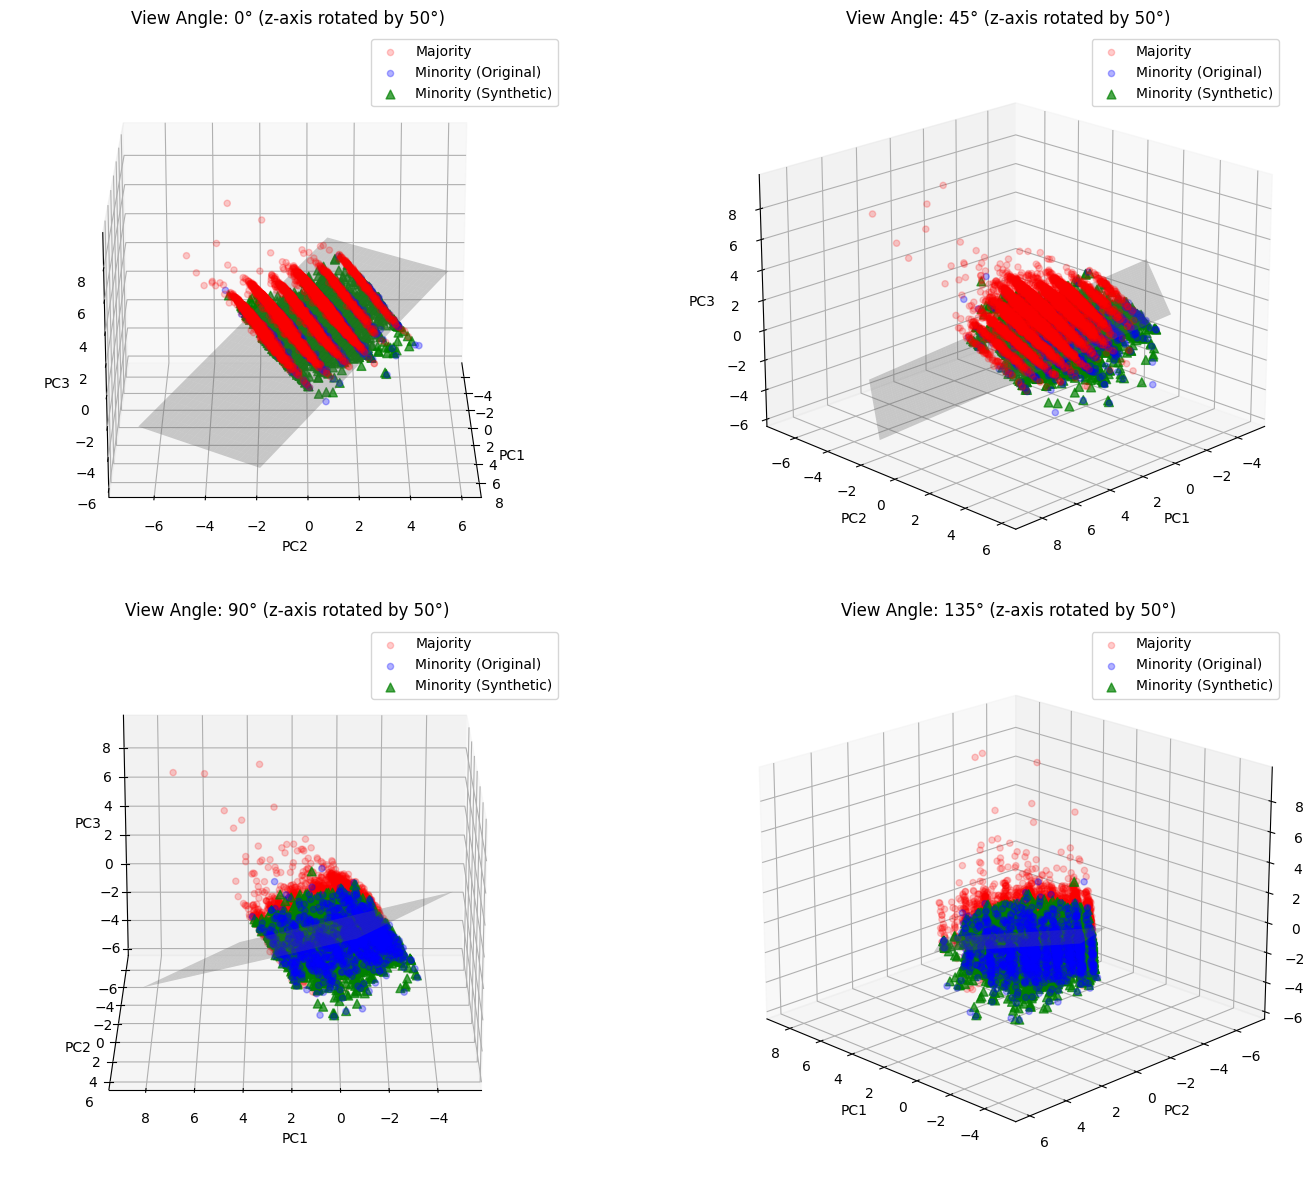

Test Accuracy (after SMOTE, TomekLinks & PCA): 0.392


In [53]:

#############################################
#  Apply SMOTE to oversample the minority class
#############################################
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tomek, y_train_tomek)

# Identify which minority samples are synthetic.
# For binary classification,  minority label is 1.
# Count original minority samples (before SMOTE)
n_min_orig = np.sum(y_train_tomek == 1)
# Count minority samples after SMOTE
n_min_new = np.sum(y_train_smote == 1)
# Synthetic samples are the extra ones added
synthetic_count = n_min_new - n_min_orig

# Get indices for each class in the SMOTE output
maj_indices = np.where(y_train_smote == 0)[0]
min_indices = np.where(y_train_smote == 1)[0]

if synthetic_count > 0:
    # Assume the ordering is such that the first n_min_orig minority samples
    # are the original ones, and the remaining are synthetic.
    orig_min_indices = min_indices[:-synthetic_count]
    synth_min_indices = min_indices[-synthetic_count:]
else:
    orig_min_indices = min_indices
    synth_min_indices = np.array([], dtype=int)

#############################################
# Apply PCA to reduce to 3 components
#############################################
pca = PCA(n_components=3)
X_train_pca_3d = pca.fit_transform(X_train_smote)

#############################################
# Train a Logistic Regression model
#############################################
model = LogisticRegression()
model.fit(X_train_pca_3d, y_train_smote)

# Extract coefficients for the decision plane: w1*x + w2*y + w3*z + b = 0
w1, w2, w3 = model.coef_[0]
b = model.intercept_[0]

#############################################
#Create a mesh grid for the decision plane
#############################################
x_vals = np.linspace(X_train_pca_3d[:, 0].min(), X_train_pca_3d[:, 0].max(), 30)
y_vals = np.linspace(X_train_pca_3d[:, 1].min(), X_train_pca_3d[:, 1].max(), 30)
xx, yy = np.meshgrid(x_vals, y_vals)
# Calculate z from the plane equation: z = -(w1*x + w2*y + b)/w3
zz = -(w1 * xx + w2 * yy + b) / w3


# Define the additional rotation angle about the z-axis (in degrees)
z_rotation_angle = 50  # Adjust as desired

# Rotate the PCA data and decision plane
X_train_pca_3d_rot = rotate_data_z(X_train_pca_3d, z_rotation_angle)
xx_rot, yy_rot, zz_rot = rotate_z_points(xx, yy, zz, z_rotation_angle)

#############################################
#Visualize the rotated data and decision plane from multiple angles
#############################################
# Colors:
# - Majority class: red
# - Original minority: blue
# - Synthetic minority: green

angles = [0, 45, 90, 135]  # Different azimuth angles for visualization
fig = plt.figure(figsize=(16, 12))

for i, view_angle in enumerate(angles, 1):
    ax = fig.add_subplot(2, 2, i, projection='3d')
    
    # Plot majority class points
    ax.scatter(
        X_train_pca_3d_rot[maj_indices, 0],
        X_train_pca_3d_rot[maj_indices, 1],
        X_train_pca_3d_rot[maj_indices, 2],
        c='red',
        label='Majority',
        alpha=0.2,
        s=20
    )
    
    # Plot original minority points
    ax.scatter(
        X_train_pca_3d_rot[orig_min_indices, 0],
        X_train_pca_3d_rot[orig_min_indices, 1],
        X_train_pca_3d_rot[orig_min_indices, 2],
        c='blue',
        label='Minority (Original)',
        alpha=0.3,
        s=20
    )
    
    # Plot synthetic minority points (if any)
    if len(synth_min_indices) > 0:
        ax.scatter(
            X_train_pca_3d_rot[synth_min_indices, 0],
            X_train_pca_3d_rot[synth_min_indices, 1],
            X_train_pca_3d_rot[synth_min_indices, 2],
            c='green',
            label='Minority (Synthetic)',
            alpha=0.7,
            s=40,
            marker='^'
        )
    
    # Plot the rotated decision plane
    ax.plot_surface(xx_rot, yy_rot, zz_rot, color='gray', alpha=0.3, edgecolor='none')
    
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.view_init(elev=20, azim=view_angle)
    ax.set_title(f'View Angle: {view_angle}° (z-axis rotated by {z_rotation_angle}°)')
    ax.legend()

plt.tight_layout()
plt.show()

#############################################
# Compute test set precision
#############################################
# Transform the test set using the PCA fitted on the training data (do NOT apply SMOTE/TomekLinks to test data)
X_test_pca_3d = pca.transform(X_test_transformed)
y_pred_test = model.predict(X_test_pca_3d)
precisio_test = precision_score(y_test, y_pred_test)
print(f"Test Accuracy (after SMOTE, TomekLinks & PCA): {precisio_test:.3f}")


As one can see the synthetic data are mixed between the two classes, this can explain why we get so many false positives.

On the basis of this osservation I will apply some "intuitive" changes to the best model pipline to try if I get better results

In [54]:
best_model_pipeline_int = IMBPipeline([
    ('trans', final_transformation),
    ('over_sampler', SMOTE(sampling_strategy=0.4, k_neighbors=2)),
    ('under_sampler', TomekLinks(sampling_strategy='majority')),
    ('dim_reduction', SFS(cv=None, estimator=Perceptron(), k_features=(9, 9),
                          scoring='f1')),
    ('classifier',SVC())
])

In [55]:
best_model_pipeline_int.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('pipe1',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['Customer_Age',
                                                   'Months_Inactive_12_mon',
                                                   'Total_Amt_Chng_Q4_Q1',
                                                   'Total_Trans_Ct',
                                                   'Total_Ct_Chng_Q4_Q1']),
                                                 ('pipe2',
                                                  Pipeline(steps=[('ord_encoder',
                                                                   OrdinalEncoder(categories...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('hot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Marital_Status',
                                                   'Gender'])],
                                   verbose_feature_names_out=False)),
                ('over_sampler', SMOTE(k_neighbors=2, sampling_strategy=0.4)),
                ('under_sampler', TomekLinks(sampling_strategy='majority')),
                ('dim_reduction',
                 SequentialFeatureSelector(cv=None, estimator=Perceptron(),
                                           k_features=(9, 9), scoring='f1')),
                ('classifier', SVC())])

In [56]:
y_pred = best_model_pipeline_int.predict(X_test)
f1_score(y_test, y_pred)

0.7052023121387283

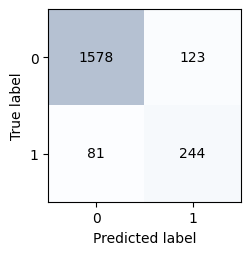

In [57]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred) #compute the confusion matrix 

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j],
                va='center', ha='center')

ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [58]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.90
Precision: 0.66
Recall: 0.75


As we can see the precision did improve, now we have less false positives. 

## Possible improvements

Instead of dropping the features another possibility is to analyze the interaction between the features and add those to the dataset. 

For example one could integrate in this dataset the feature "tenure_per transaction" computed as the ration between "months_on_book" and "total transaction_ct" (+1 to avoid the division by zero). 
This feature would represent how much a customer takes on average to make a transaction over their bank account lifespan. In this case a high value might indicate that a customer has been with the bank for long time but has been making very little transactions, flagging this customer as prone to churn. On the contrary, low values for this feature migh mean that the customer is engaging with the product. 

In [59]:
#data["tenure_per_transaction"] = data["Months_on_book"] / (X["Total_Trans_Ct"] + 1)

#px.histogram(data, x="tenure_per_transaction", title="Tenure per transaction")


Another possibility is to, instead of using Months_Inactive_12_mon alone, combine Months_Inactive_12_mon with other inactivity indicators (like Total_Trans_Ct). This is to represent ralative inactivity over time

In [60]:
#data["inactivity_ratio"] = data["Months_Inactive_12_mon"] / (data["Months_on_book"] + 1)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3c027215-1ee4-4e90-9d16-b00a265ece7f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>